### Uplift modeling

Uplift modeling: http://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf  
  
dataset: https://ailab.criteo.com/criteo-uplift-prediction-dataset/
- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
- treatment: treatment group (1 = treated, 0 = control)
- conversion: whether a conversion occured for this user (binary, label)
- visit: whether a visit occured for this user (binary, label)
- exposure: treatment effect, whether the user has been effectively exposed (binary)  
  
What would I do:  
Target conversion to improve  
やりたいこと：  
コンバージョン率を上げるため、実施したABテストの結果を検討  
https://ohke.hateblo.jp/entry/2019/01/05/230000

### First model: 2 model approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/criteo-uplift.csv')
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,1.991981,3.263641,9.241052,3.735871,3.506733,10.161281,2.981721,-0.166689,-0.584392,9.850093,-1.8609,4.157648,1,0,0,0
1,1.991981,3.263641,9.274430,3.735871,3.506733,10.161281,2.981721,-0.166689,-0.584392,9.850093,-1.8609,4.157648,1,0,0,0
2,1.991981,3.263641,9.226241,3.735871,3.506733,10.161281,2.981721,-0.166689,-0.584392,9.850093,-1.8609,4.157648,1,0,0,0
3,1.991981,3.263641,9.274572,3.735871,3.506733,10.161281,2.981721,-0.166689,-0.584392,9.850093,-1.8609,4.157648,1,0,0,0
4,1.991981,3.263641,9.332619,3.735871,3.506733,10.161281,2.981721,-0.166689,-0.584392,9.850093,-1.8609,4.157648,0,0,0,0


In [3]:
data.shape

(25309482, 16)

In [4]:
# data divide treatment
treatment_df = data[data['treatment'] == 1]#.sample(n=1000000)
control_df = data[data['treatment'] == 0]#.sample(n=1000000)

In [5]:
# devide train and test data
X_control_train, X_control_test, y_control_train, y_control_test = train_test_split(
    control_df[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']],
    control_df['conversion'], random_state=74)
X_treatment_train, X_treatment_test, y_treatment_train, y_treatment_test = train_test_split(
    treatment_df[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']],
    treatment_df['conversion'], random_state=74, test_size=len(y_control_test))

In [6]:
# treatment model 
treatment_model = LogisticRegression()
treatment_model.fit(X_treatment_train, y_treatment_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
for column, coef in zip(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'], treatment_model.coef_[0]):
    print(f'{column}: {coef}')

f0: 0.3336727769962025
f1: 0.10213562092847434
f2: -1.379971490052935
f3: -0.04402118201515236
f4: 1.268941047717686
f5: -0.18707973187529506
f6: -0.18248639066418265
f7: -0.07140426198164587
f8: -0.07518320408186532
f9: 0.06471295953487242
f10: -0.08058443418348511
f11: 3.5132680155803158


In [8]:
# control model
control_model = LogisticRegression()
control_model.fit(X_control_train, y_control_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
for column, coef in zip(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'], control_model.coef_[0]):
    print(f'{column}: {coef}')

f0: 0.45944955775366203
f1: -0.10719056559002228
f2: -1.828409216835395
f3: 0.1538197580320436
f4: 1.3734169030307994
f5: -0.1964463354558963
f6: -0.110614375580372
f7: -0.0684662877439304
f8: -0.07045476690626283
f9: 0.08349497685505892
f10: -0.08658061945561132
f11: 2.416508066080495


TODO: 英語でここまでの結論まとめる  
  
  
施策の有無に左右されず、f4とf11がコンバージョンに寄与している模様

In [11]:
# アップリフト = 施策実施時の予測反応確率 / 施策非実施時の予測反応確率
result_df = pd.DataFrame()
result_df['treatment'] = treatment_model.predict_proba(X_treatment_test).flatten()
result_df['control']= control_model.predict_proba(X_control_test).flatten()
result_df['uplift'] = result_df['treatment'] / result_df['control']
result_df

,treatment,control,uplift
0,0.999431,0.999812,0.999619
1,0.000569,0.000188,3.030989
2,0.999478,0.999725,0.999754
3,0.000522,0.000275,1.894573
4,0.998948,0.998697,1.000251
...,...,...,...
1950323,0.001052,0.000453,2.323428
1950324,0.998948,0.999726,0.999222
1950325,0.001052,0.000274,3.836895
1950326,0.999518,0.998697,1.000822


In [12]:
result_df.describe()

,treatment,control,uplift
count,1.950328e+06,1.950328e+06,1.950328e+06
mean,5.000000e-01,5.000000e-01,3.403338e+00
std,4.979054e-01,4.984794e-01,4.943358e+01
min,8.255153e-05,3.673446e-05,1.223099e-04
25%,8.970973e-04,4.688711e-04,9.987213e-01
50%,5.000000e-01,5.000000e-01,1.000000e+00
75%,9.991029e-01,9.995311e-01,1.393391e+00
max,9.999174e-01,9.999633e-01,1.792893e+04


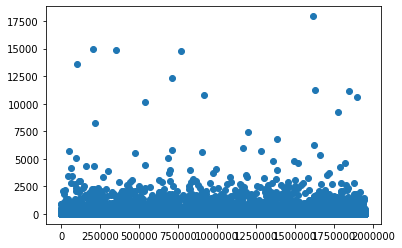

In [15]:
# Visualize uplift value
plt.scatter(range(len(result_df)), result_df['uplift'])

In [24]:
# upliftの値が2500以上のデータを抽出
print(result_df[result_df['uplift']>2500].shape)
positive_cluster_df = data.iloc[list(result_df[result_df['uplift']>2500].index)]
positive_cluster_df.head()

(91, 3)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
44755,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0
50627,1.991981,3.263641,8.967908,3.735871,3.506733,10.161281,2.981721,-0.166689,-6.006161,9.850093,-1.8609,4.157648,1,0,0,0
61263,0.205012,3.263641,9.172990,3.471742,3.506733,10.161281,1.963442,-0.166689,-3.476821,9.850093,-1.8609,4.157648,1,0,0,0
63813,0.188060,3.263641,9.149015,3.386711,3.506733,10.161281,-1.044755,-0.166689,-9.753175,9.850093,-1.8609,4.157648,1,0,0,0
69017,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0


In [26]:
positive_cluster_df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,91.000000,9.100000e+01,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,9.100000e+01,91.000000,91.0,91.000000,91.000000
mean,0.526364,3.263641e+00,8.539001,3.689467,3.517352,10.183675,1.845861,-0.293890,-1.514930,10.431562,-2.050072,4.157648e+00,0.846154,0.0,0.032967,0.043956
std,1.613645,4.465496e-16,0.390826,0.146643,0.076472,0.121962,1.537699,0.699135,5.051872,2.003514,1.269287,8.930991e-16,0.362800,0.0,0.179540,0.206133
min,-1.945838,3.263641e+00,8.272483,2.667629,3.506733,10.161281,-4.123098,-4.667953,-24.936498,9.850093,-10.670276,4.157648e+00,0.000000,0.0,0.000000,0.000000
25%,-1.161240,3.263641e+00,8.272483,3.735871,3.506733,10.161281,1.254558,-0.166689,-1.784858,9.850093,-1.860900,4.157648e+00,1.000000,0.0,0.000000,0.000000
50%,1.537200,3.263641e+00,8.272483,3.735871,3.506733,10.161281,2.386066,-0.166689,1.107571,9.850093,-1.860900,4.157648e+00,1.000000,0.0,0.000000,0.000000
75%,1.991981,3.263641e+00,8.967890,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648e+00,1.000000,0.0,0.000000,0.000000
max,1.991981,3.263641e+00,9.324140,3.735871,4.176598,10.840586,2.981721,-0.166689,1.107571,24.141166,-1.860900,4.157648e+00,1.000000,0.0,1.000000,1.000000


### Conclusion
施策を実施した方が良い条件は以下の通り
- f1: acound 3.2, 
- f2: around 8,
- f3: around 3.7,
- f4: around 3.5,
- f5: around 10.16,
- f10: around -1.86,
- f11: around 4.15